In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
#from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [2]:

def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, type_, p, drop_interval_begin = 3, drop_interval_end = 3):
    
#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
        
    #drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie
        
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])
    

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    data['type'] = type_
    data['proefpersoon'] = p
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
    #last samples 
    yield (df.iloc[-1] - pd.to_timedelta(time, unit='s')), df.iloc[-1]
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 52

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df

#3 keer savgol filter uitvoeren met 33,5
def get_turns_smooth_side_swing(df):
    for i in range(0,5):
        df['x'] = savgol_filter(df[ 'x'].to_numpy(), 101, 5)
        df['y'] = savgol_filter(df[ 'y'].to_numpy(), 101, 5)
        df['z'] = savgol_filter(df[ 'z'].to_numpy(), 101, 5)
        df.plot(x='time', subplots=True)

    wx = find_peaks(df['x'])
    wy = find_peaks(df['y'])
    wz = find_peaks(df['z'])
    return (len(wx[0]) + len(wy[0]) + len(wz[0]))/3


column_names_org = ['time', 'x', 'y', 'z']

In [3]:
raw = True
freq = 0

# <font color='green' >PROEFPERSOON 1

## cross over
copy of proefpersoon2!!!!

In [4]:
cross_over_left_forward_1 = []
cross_over_left_backwards_1 = []
cross_over_right_forward_1 = []
cross_over_right_backwards_1 = []

# <font color='green' >PROEFPERSOON 2

## cross over

In [5]:
cross_over_left_forward_2 = []
cross_over_left_backwards_2 = []
cross_over_right_forward_2 = []
cross_over_right_backwards_2 = []

#### cross_over_left_forward

In [6]:
cross_over2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over2.csv", sep=';', header=0, skipinitialspace=True)
cross_over3 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over3.csv", sep=';', header=0, skipinitialspace=True)
cross_over4 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over4.csv", sep=';', header=0, skipinitialspace=True)
cross_over5 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over5.csv", sep=';', header=0, skipinitialspace=True)
cross_over6 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_left_forward4.csv", sep=';', header=0, skipinitialspace=True)
cross_over7 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_left_forward3.csv", sep=';', header=0, skipinitialspace=True)
cross_over9 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_left_forward1.csv", sep=';', header=0, skipinitialspace=True)

cross_over_fast = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_left_forward_fast_2sessies.csv", sep=';', header=0, skipinitialspace=True)
cross_over_fast1 = cross_over_fast[cross_over_fast['time'] < 49380000000000]
cross_over_fast2 = cross_over_fast[cross_over_fast['time'] > 49380000000000]

cross_over2 = preprocess(cross_over2, "cross_over_slow", "left_forward", 2)
cross_over3 = preprocess(cross_over3, "cross_over_slow", "left_forward", 2)
cross_over4 = preprocess(cross_over4, "cross_over_slow", "left_forward", 2)
cross_over5 = preprocess(cross_over5, "cross_over_slow", "left_forward", 2)
cross_over6 = preprocess(cross_over6, "cross_over_slow", "left_forward", 2)
cross_over7 = preprocess(cross_over7, "cross_over_slow", "left_forward", 2,5,5)
cross_over9 = preprocess(cross_over9, "cross_over_slow", "left_forward", 2)
cross_over_fast1 = preprocess(cross_over_fast1, "cross_over_fast", "left_forward", 2, 13.7, 45)
cross_over_fast2 = preprocess(cross_over_fast2, "cross_over_fast", "left_forward", 2, 32.7, 2.2)

cross_over_left_forward_slow_2 = [cross_over2, cross_over3, cross_over4, cross_over5, cross_over6, cross_over7, cross_over9]

cross_over_left_forward_fast_2 = [cross_over_fast1, cross_over_fast2]

In [8]:

for df in cross_over_left_forward_2:
    f = sampling_freq(df)
    freq += f

#### cross_over_left_backwards

In [9]:
cross_over_left_backwards1 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_backwards.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_backwards(2).csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards3 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossOver_left_backwards.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards4 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossOver_left_backwards2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards5 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossOver_left_backwards3.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards6 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_left_backwards1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards7 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_left_backwards2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards_fast1 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_left_backwards_fast1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards_fast2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_left_backwards_fast2.csv", sep=';', header=0, skipinitialspace=True)


cross_over_left_backwards1 = preprocess(cross_over_left_backwards1, "cross_over_slow", "left_backwards", 2)
cross_over_left_backwards2 = preprocess(cross_over_left_backwards2, "cross_over_slow", "left_backwards", 2)
cross_over_left_backwards3 = preprocess(cross_over_left_backwards3, "cross_over_slow", "left_backwards", 2 ,3,8)
cross_over_left_backwards4 = preprocess(cross_over_left_backwards4, "cross_over_slow", "left_backwards", 2)
cross_over_left_backwards5 = preprocess(cross_over_left_backwards5, "cross_over_slow", "left_backwards", 2)
cross_over_left_backwards6 = preprocess(cross_over_left_backwards6, "cross_over_slow", "left_backwards", 2 ,3,5)
cross_over_left_backwards7 = preprocess(cross_over_left_backwards7, "cross_over_slow", "left_backwards", 2 ,5,6)
cross_over_left_backwards_fast1 = preprocess(cross_over_left_backwards_fast1, "cross_over_fast", "left_backwards", 2 ,3.5,4.5)
cross_over_left_backwards_fast2 = preprocess(cross_over_left_backwards_fast2, "cross_over_fast", "left_backwards", 2 ,2.5,3.3)

cross_over_left_backwards_slow_2 = [cross_over_left_backwards1, cross_over_left_backwards2, cross_over_left_backwards3, 
                               cross_over_left_backwards4, cross_over_left_backwards5, cross_over_left_backwards6, cross_over_left_backwards7]

cross_over_left_backwards_fast_2 = [cross_over_left_backwards_fast1, cross_over_left_backwards_fast2]

In [10]:
cross_over_left_backwards_fast1.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB60055FC8>,
      dtype=object)

In [12]:

for df in cross_over_left_backwards_2:
    f = sampling_freq(df)
    freq += f

#### cross_over_right_forward

In [13]:
cross_over_right_forward1 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossOver_right_forward1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossOver_right_forward2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward3 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossOver_right_forward3.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward4 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_forward2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward5 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_forward1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward_fast1 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_right_forward_fast1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward_fast2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_right_forward_fast2.csv", sep=';', header=0, skipinitialspace=True)


cross_over_right_forward1 = preprocess(cross_over_right_forward1, "cross_over_slow", "right_forward", 2)
cross_over_right_forward2 = preprocess(cross_over_right_forward2, "cross_over_slow", "right_forward", 2)
cross_over_right_forward3 = preprocess(cross_over_right_forward3, "cross_over_slow", "right_forward", 2)
cross_over_right_forward4 = preprocess(cross_over_right_forward4, "cross_over_slow", "right_forward", 2)
cross_over_right_forward5 = preprocess(cross_over_right_forward5, "cross_over_slow", "right_forward", 2)
cross_over_right_forward_fast1 = preprocess(cross_over_right_forward_fast1, "cross_over_fast", "right_forward", 2,2.8,2.3)
cross_over_right_forward_fast2 = preprocess(cross_over_right_forward_fast2, "cross_over_fast", "right_forward", 2,3.2,1.8)

cross_over_right_forward_slow_2 = [cross_over_right_forward1, cross_over_right_forward2, cross_over_right_forward3, 
                              cross_over_right_forward4, cross_over_right_forward5]

cross_over_right_forward_fast_2 = [cross_over_right_forward_fast1, cross_over_right_forward_fast2]

<IPython.core.display.Javascript object>


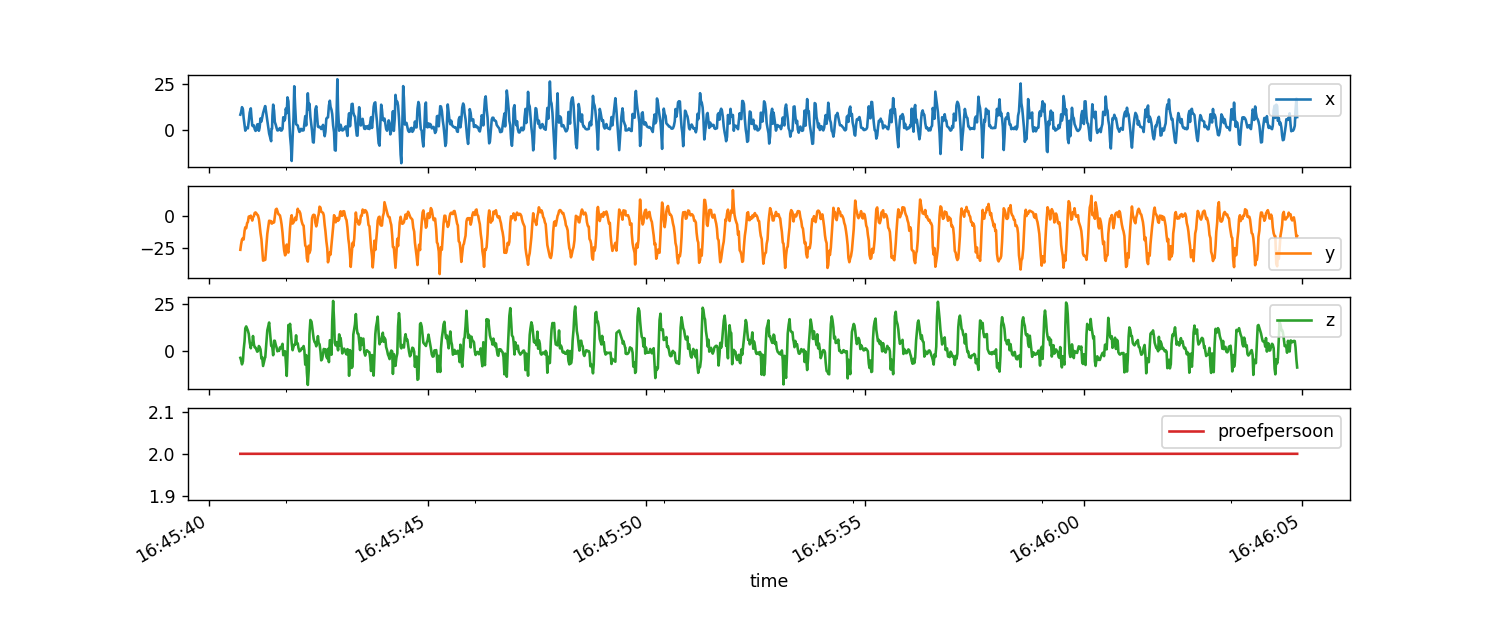

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB60193E88>,
      dtype=object)

In [14]:
cross_over_right_forward_fast1.plot(x='time', subplots=True)

In [17]:

for df in cross_over_right_forward_2:
    f = sampling_freq(df)
    freq += f

#### cross_over_right_backwards

In [18]:
cross_over_right_backwards1 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_backwards1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards3 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_backwards3.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards4 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_backwards1(2).csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards5 = pd.read_csv(r"..\data\cross_over\proefpersoon2\cross_over_right_backwards2(2).csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards_fast1 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_right_backwards_fast1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards_fast2 = pd.read_csv(r"..\data\cross_over\proefpersoon2\crossover_right_backwards_fast2.csv", sep=';', header=0, skipinitialspace=True)

cross_over_right_backwards1 = preprocess(cross_over_right_backwards1, "cross_over_slow", "right_backwards", 2)
cross_over_right_backwards2 = preprocess(cross_over_right_backwards2, "cross_over_slow", "right_backwards", 2 , 3, 5)
cross_over_right_backwards3 = preprocess(cross_over_right_backwards3, "cross_over_slow", "right_backwards", 2 ,3,5)
cross_over_right_backwards4 = preprocess(cross_over_right_backwards4, "cross_over_slow", "right_backwards", 2 ,3,5)
cross_over_right_backwards5 = preprocess(cross_over_right_backwards5, "cross_over_slow", "right_backwards", 2)
cross_over_right_backwards_fast1 = preprocess(cross_over_right_backwards_fast1, "cross_over_fast", "right_backwards", 2,2.6,3)
cross_over_right_backwards_fast2 = preprocess(cross_over_right_backwards_fast2, "cross_over_fastcross_over_slowcross_over_slow", "right_backwards", 2,2.3,2)

cross_over_right_backwards_slow_2 = [cross_over_right_backwards1, cross_over_right_backwards2, cross_over_right_backwards3, 
                                cross_over_right_backwards4, cross_over_right_backwards5]

cross_over_right_backwards_fast_2 = [ cross_over_right_backwards_fast1, cross_over_right_backwards_fast2]

<IPython.core.display.Javascript object>


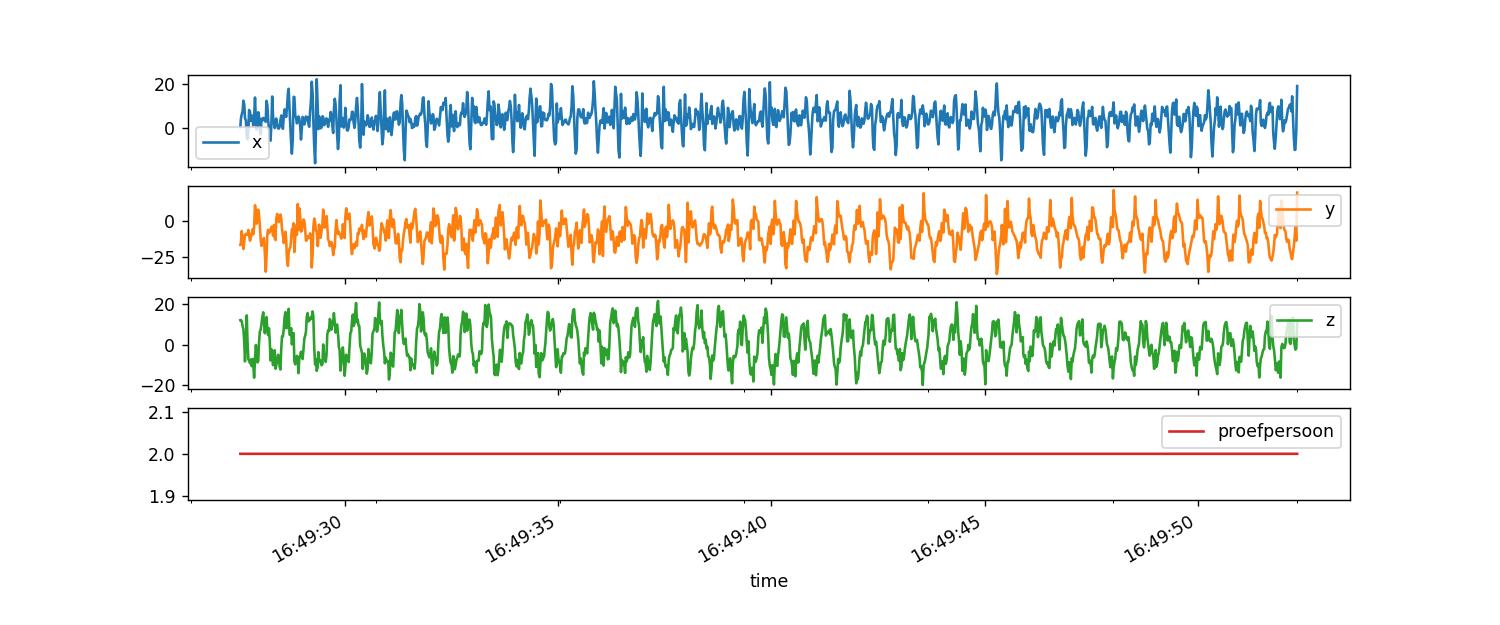

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB604303C8>,
      dtype=object)

In [19]:
cross_over_right_backwards_fast2.plot(x='time', subplots=True)

In [20]:
for df in cross_over_right_backwards_2:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [21]:
if(not raw):
    #segmentation + feature extraction
    for i in range(0, len(cross_over_left_forward_2)):
        cross_over_left_forward_2[i] =  feature_extraction_segmentation(cross_over_left_forward_2[i],1, True)

    for i in range(0, len(cross_over_left_backwards_2)):
        cross_over_left_backwards_2[i] =  feature_extraction_segmentation(cross_over_left_backwards_2[i],1, True)

    for i in range(0, len(cross_over_right_forward_2)):
        cross_over_right_forward_2[i] =  feature_extraction_segmentation(cross_over_right_forward_2[i],1, True)

    for i in range(0, len(cross_over_right_backwards_2)):
        cross_over_right_backwards_2[i] =  feature_extraction_segmentation(cross_over_right_backwards_2[i],1, True)

In [22]:
cross_over_right_backwards_slow_2 = pd.concat(cross_over_right_backwards_slow_2, ignore_index=True)
cross_over_right_backwards_slow_2.shape

(6713, 7)

In [23]:
cross_over_right_forward_slow_2 = pd.concat(cross_over_right_forward_slow_2, ignore_index=True)
cross_over_right_forward_slow_2.shape

(6050, 7)

In [24]:
cross_over_left_forward_slow_2 = pd.concat(cross_over_left_forward_slow_2, ignore_index=True)
cross_over_left_forward_slow_2.shape

(9196, 7)

In [25]:
cross_over_left_backwards_slow_2 = pd.concat(cross_over_left_backwards_slow_2, ignore_index=True)
cross_over_left_backwards_slow_2.shape

(9580, 7)

In [ ]:
cross_over_right_backwards_fast_2 = pd.concat(cross_over_right_backwards_fast_2, ignore_index=True)
cross_over_right_backwards_fast_2.shape

In [ ]:
cross_over_right_forward_fast_2 = pd.concat(cross_over_right_forward_fast_2, ignore_index=True)
cross_over_right_forward_fast_2.shape

In [ ]:
cross_over_left_forward_fast_2 = pd.concat(cross_over_left_forward_fast_2, ignore_index=True)
cross_over_left_forward_fast_2.shape

In [ ]:
cross_over_left_backwards_fast_2 = pd.concat(cross_over_left_backwards_fast_2, ignore_index=True)
cross_over_left_backwards_fast_2.shape

### SHUFFLE - BALANCING

In [26]:
shape = np.min([
    cross_over_right_backwards_2.shape[0], 
    cross_over_right_forward_2.shape[0], 
    cross_over_left_forward_2.shape[0], 
    cross_over_left_backwards_2.shape[0]])

#### shuffle

In [27]:
''' 
cross_over_right_backwards_2 = shuffle(cross_over_right_backwards_2).head(shape).copy()
cross_over_right_forward_2 = shuffle(cross_over_right_forward_2).head(shape).copy()
cross_over_left_forward_2 = shuffle(cross_over_left_forward_2).head(shape).copy()
cross_over_left_backwards_2 = shuffle(cross_over_left_backwards_2).head(shape).copy()'''

' \ncross_over_right_backwards_2 = shuffle(cross_over_right_backwards_2).head(shape).copy()\ncross_over_right_forward_2 = shuffle(cross_over_right_forward_2).head(shape).copy()\ncross_over_left_forward_2 = shuffle(cross_over_left_forward_2).head(shape).copy()\ncross_over_left_backwards_2 = shuffle(cross_over_left_backwards_2).head(shape).copy()'

#### no shuffle

In [28]:
''' 
cross_over_right_backwards_2 = cross_over_right_backwards_2.head(shape).copy()
cross_over_right_forward_2 = cross_over_right_forward_2.head(shape).copy()
cross_over_left_forward_2 = cross_over_left_forward_2.head(shape).copy()
cross_over_left_backwards_2 = cross_over_left_backwards_2.head(shape).copy()'''

' \ncross_over_right_backwards_2 = cross_over_right_backwards_2.head(shape).copy()\ncross_over_right_forward_2 = cross_over_right_forward_2.head(shape).copy()\ncross_over_left_forward_2 = cross_over_left_forward_2.head(shape).copy()\ncross_over_left_backwards_2 = cross_over_left_backwards_2.head(shape).copy()'

In [29]:
#cross_over_2 = pd.concat([cross_over_right_backwards_2, cross_over_right_forward_2, cross_over_left_forward_2, cross_over_left_backwards_2])

# <font color='green'> Frequency

In [30]:
#mean
freq = freq/30
freq

56.181206478719346

# <font color='green'> Merging datasets

In [31]:
shape = np.min([
    #cross_over_1.shape[0],
    cross_over_2.shape[0]
])

NameError: name 'cross_over_2' is not defined

#### shuffle

In [32]:
''' 
dataset = pd.concat([
    #shuffle(cross_over_1).head(shape),
    shuffle(cross_over_2).head(shape)
])
dataset.shape'''

' \ndataset = pd.concat([\n    #shuffle(cross_over_1).head(shape),\n    shuffle(cross_over_2).head(shape)\n])\ndataset.shape'

#### no shuffle

In [ ]:
''' 
dataset = pd.concat([
    #shuffle(cross_over_1).head(shape),
    cross_over_2.head(shape)
])
dataset.shape'''

In [33]:
cross_over_right_backwards_slow = pd.concat([
    cross_over_right_backwards_slow_2
])
cross_over_left_backwards_slow = pd.concat([
    cross_over_left_backwards_slow_2
])
cross_over_right_forward_slow = pd.concat([

    cross_over_right_forward_slow_2
])
cross_over_left_forward_slow = pd.concat([

    cross_over_left_forward_slow_2
])
cross_over_left_forward.shape

(9196, 7)

In [ ]:
cross_over_right_backwards_fast = pd.concat([
    cross_over_right_backwards_fast_2
])
cross_over_left_backwards_fast = pd.concat([
    cross_over_left_backwards_fast_2
])
cross_over_right_forward_fast = pd.concat([

    cross_over_right_forward_fast_2
])
cross_over_left_forward_fast = pd.concat([

    cross_over_left_forward_fast_2
])

In [34]:
cross_over_right_backwards_slow.to_csv("cross_over_right_backwards_slow.csv", sep=';')
cross_over_left_backwards_slow.to_csv("cross_over_left_backwards_slow.csv", sep=';')
cross_over_right_forward_slow.to_csv("cross_over_right_forward_slow.csv", sep=';')
cross_over_left_forward_slow.to_csv("cross_over_left_forward_slow.csv", sep=';')

In [ ]:
cross_over_right_backwards_fast.to_csv("cross_over_right_backwards_fast.csv", sep=';')
cross_over_left_backwards_fast.to_csv("cross_over_left_backwards_fast.csv", sep=';')
cross_over_right_forward_fast.to_csv("cross_over_right_forward_fast.csv", sep=';')
cross_over_left_forward_fast.to_csv("cross_over_left_forward_fast.csv", sep=';')

In [ ]:
#dataset.to_csv("cross_over_raw.csv", sep=';')